## Principal Component Analysis
We will use the Fashion-MNIST dataset to build a PCA model (i.e. eigenvectors and eigenvalues). <br>
https://github.com/zalandoresearch/fashion-mnist <br>
Then, we will use the PCA model to <br>
(1) visualize the data in 2D <br>
(2) generate new images as a generative model <br>

#### First, we load the dataset

In [1]:
# load the data
from sklearn.datasets import fetch_openml
fasion_mnist=fetch_openml(name="Fashion-MNIST")

In [2]:
data=fasion_mnist.data
images=data.reshape(-1,28,28)
target=fasion_mnist.target.astype('int64')

In [3]:
#a row in data is an image (28x28 reshaped into a vector of 784 elements)
data.shape

(70000, 784)

In [4]:
# images[0] is the first image (28x28)
images.shape

(70000, 28, 28)

In [5]:
#an element in target is the class label of the corresponding image in data
target.shape

(70000,)

In [6]:
[target.min(), target.max()]

[0, 9]

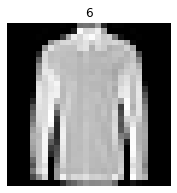

<Figure size 432x288 with 0 Axes>

In [7]:
# show some of the images
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
fig, ax = plt.subplots(figsize=(3, 3))
for n in range(0, target.shape[0], 1000):
    x=data[n,:]
    x=x.reshape(28,28) # reshape a vector to an image
    ax.imshow(x, cmap='gray')    
    ax.axis('off')
    ax.set_title(target[n])
    plt.draw()
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.1)  

#### we need the function plot_components for visualization

In [8]:
from matplotlib import offsetbox
import numpy as np
def plot_components(data, model, images, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

In [9]:
#using IncrementalPCA (instead of original PCA) in sk-learn
#it runs faster to get the eigenvectors and eigenvalues
#it is more memory efficient
from sklearn.decomposition import PCA, IncrementalPCA
pca = IncrementalPCA(n_components=2, whiten=True)
pca.fit(data)

IncrementalPCA(batch_size=None, copy=True, n_components=2, whiten=True)

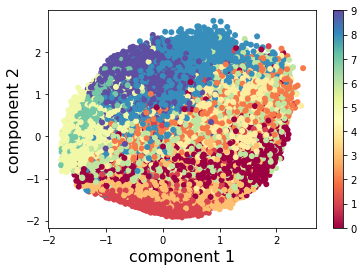

In [10]:
#show the data points in 2D
Y = pca.transform(data)
plt.scatter(Y[:, 0], Y[:, 1], 
            c=target, 
            edgecolor='none',
            cmap='Spectral')
plt.xlabel('component 1', fontsize=16)
plt.ylabel('component 2', fontsize=16)
plt.colorbar()

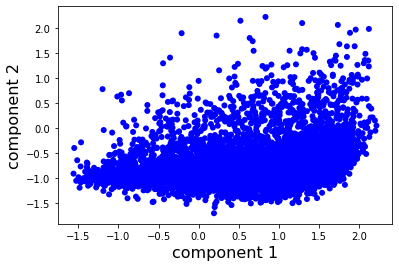

In [11]:
plt.scatter(Y[target==0, 0], Y[target==0, 1],
            c='blue', 
            edgecolor='none')
plt.xlabel('component 1', fontsize=16)
plt.ylabel('component 2', fontsize=16)
plt.show()

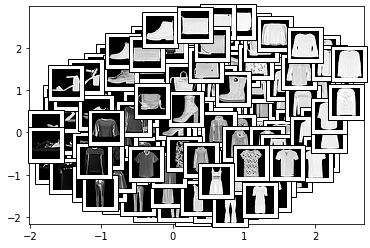

In [12]:
# using plot_components to show the data points
plot_components(data,pca,images=images)

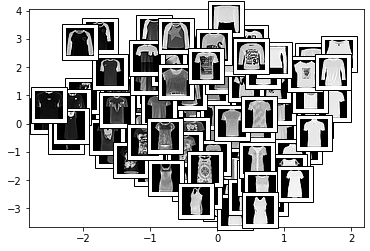

In [13]:
# using plot_components to show the data points with class label=0
plot_components(data[target==0],pca,images=images[target==0])

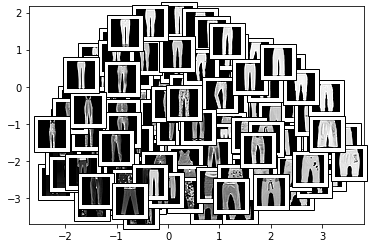

In [14]:
# using plot_components to show the data points with class label=1
plot_components(data[target==1],pca,images=images[target==1])

From the above examples, we can see that PCA can extract meaningful features from the images 

### 2. Using PCA to generate new images 

First, we need to figure out how many components we need

In [15]:
pca = IncrementalPCA(n_components=100)
pca.fit_transform(data)

array([[-1.26502892e+02,  1.63243235e+03, -1.20922161e+03, ...,
         7.79606836e+00,  1.43638785e+01,  4.94813815e+01],
       [ 1.40756478e+03, -4.51681441e+02, -2.59767321e+02, ...,
         1.21642210e+01, -3.31418601e+01,  3.81942599e+01],
       [-7.25430402e+02, -1.10359769e+03,  1.07005622e+02, ...,
         4.30613267e+00,  3.10407780e+01, -2.23766824e+00],
       ...,
       [-5.10609541e+02, -7.26945115e+02, -2.07567304e+02, ...,
         1.03371620e+02, -5.88121186e+01,  4.83049918e+01],
       [-2.20990247e+02, -1.41248269e+03, -4.42769445e+02, ...,
         1.39239352e+02, -7.46890772e+01, -9.34540346e-01],
       [-1.52114050e+03,  9.25410065e+01,  2.65696411e+02, ...,
        -5.70200770e+01, -8.37106341e+00, -1.16909522e+01]])

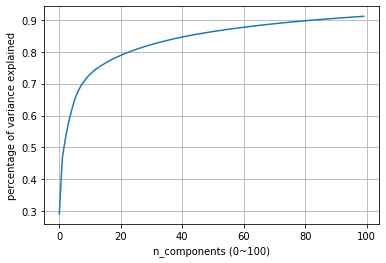

In [16]:
#plotting the curve of 'percentage of variance explained' (0~1) vs n_components (0~100)
#using explained_variance_ratio_ to compute percentage of variance explained
# explained_variance_ratio_[0:k].sum() is the percentage of variance explained using
#    eigenvectors w0, w1, ...wk 
# using plt.grid() to show grid
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('n_components (0~100)')
plt.ylabel('percentage of variance explained')
plt.grid()

In [17]:
# choosing n_component such that 
# (1) average reconstruction error < 20%
# (2) percentage of variance explained > 80%
# (1) and (2) are the same
np.cumsum(pca.explained_variance_ratio_)[23]

0.800958982226761

In [18]:
# getting the mean, eigenvalues, and eigenvectors from the above pca model
# name of mean is mu
# the name of eigenvalues is v (a 1D array)
# the name of eigenvectors is w (a 2D array)
mu=pca.mean_
w=pca.components_
v=pca.explained_variance_
print(mu.shape,w.shape,v.shape)

(784,) (100, 784) (100,)


In [19]:
v.shape

(100,)

In [20]:
w.shape

(100, 784)

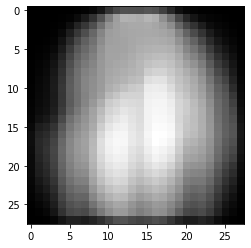

In [21]:
# plotting the mean image from pca
plt.imshow(mu.reshape(28,28), cmap='gray')

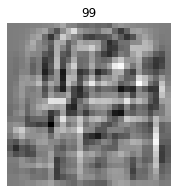

<Figure size 432x288 with 0 Axes>

In [22]:
# using a for loop  to show the images of eigenvectors
fig, ax = plt.subplots(figsize=(3, 3))
for n in range(0, 100):
    ax.imshow(w[n].reshape(28,28), cmap='gray')    
    ax.axis('off')
    ax.set_title(n)
    plt.draw()
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.2) 

In [23]:
# L2 norm of an eigenvector w[0]
np.sum(w[0]**2)

1.0000000000000013

In [24]:
# generate a random number
3*np.random.randn()

0.22929362381121876

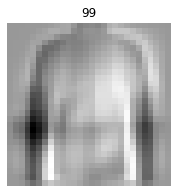

<Figure size 432x288 with 0 Axes>

In [25]:
# generate and show the new images
x_pre=w[0:23] * np.sqrt(pca.explained_variance_[0:23].reshape(23,1))
# generate some new face images
fig, ax = plt.subplots(figsize=(3, 3))
for k in range(0, 100):
    y = 3*np.random.randn(23,1)
    z = x_pre*y
    z = z.sum(axis=0)
    x_new = mu + z
    x_new = x_new.reshape(28,28)  
    ax.imshow(x_new, cmap='gray')    
    ax.axis('off')
    ax.set_title(k)
    plt.draw()
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.2) 